# MODIS file processing

#### First working with the old climatology. (new is formatted wrong)

### Add paths to run locally or off Cheyenne or Casper 
(what is the difference between these two again?)

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/Common/')
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from cloud_metric import Cloud_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from interp_functions import *

## Process MODIS observations

#### There is no time coordinate in this climatology

In [3]:
modis_dir = '/glade/work/jenkay/obs/COSP/MODIS/'
climo_file = 'MCD06COSP_M3_MODIS.200301to202012.climo.nc'

In [4]:
modis_old = xr.open_dataset('%s/%s' % (modis_dir,'MCD03_M3_NC_200207to201007.V01.nc'))

In [10]:
modis_old

<xarray.Dataset>
Dimensions:                                                  (Cloud_Optical_Thickness: 7, Cloud_Top_Pressure: 7, lat: 180, lon: 360, nbnds: 2)
Coordinates:
  * lat                                                      (lat) float32 89...
  * lon                                                      (lon) float32 -1...
  * Cloud_Optical_Thickness                                  (Cloud_Optical_Thickness) float32 ...
  * Cloud_Top_Pressure                                       (Cloud_Top_Pressure) float32 ...
Dimensions without coordinates: nbnds
Data variables:
    Cloud_Optical_Thickness_bnds                             (nbnds, Cloud_Optical_Thickness) float32 ...
    Cloud_Top_Pressure_bnds                                  (nbnds, Cloud_Top_Pressure) float32 ...
    Cloud_Top_Pressure_Total_Mean                            (lat, lon) float32 ...
    Cloud_Fraction_Mask_Total_Mean                           (lat, lon) float32 ...
    Cloud_Optical_Thickness_Liquid_Mean                      (lat, lon) float32 ...
    Cloud_Optical_Thickness_Liquid_Uncertainty_in_Mean       (lat, lon) float32 ...
    Cloud_Optical_Thickness_Liquid_Uncertainty_in_MeanLog10  (lat, lon) float32 ...
    Cloud_Optical_Thickness_Liquid_MeanLog10                 (lat, lon) float32 ...
    Cloud_Optical_Thickness_Ice_Mean                         (lat, lon) float32 ...
    Cloud_Optical_Thickness_Ice_Uncertainty_in_Mean          (lat, lon) float32 ...
    Cloud_Optical_Thickness_Ice_Uncertainty_in_MeanLog10     (lat, lon) float32 ...
    Cloud_Optical_Thickness_Ice_MeanLog10                    (lat, lon) float32 ...
    Cloud_Optical_Thickness_Total_Mean                       (lat, lon) float32 ...
    Cloud_Optical_Thickness_Total_MeanLog10                  (lat, lon) float32 ...
    Optical_Thickness_vs_Cloud_Top_Pressure                  (lat, lon, Cloud_Top_Pressure, Cloud_Optical_Thickness) float32 ...
    Cloud_Particle_Size_Liquid_Mean                          (lat, lon) float32 ...
    Cloud_Particle_Size_Liquid_Uncertainty_in_Mean           (lat, lon) float32 ...
    Cloud_Particle_Size_Ice_Mean                             (lat, lon) float32 ...
    Cloud_Particle_Size_Ice_Uncertainty_in_Mean              (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_Liquid_Mean                     (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_Ice_Mean                        (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_Total_Mean                      (lat, lon) float32 ...
    Liquid_Path_Mean                                         (lat, lon) float32 ...
    Liquid_Path_Uncertainty_in_Mean                          (lat, lon) float32 ...
    Ice_Path_Mean                                            (lat, lon) float32 ...
    Ice_Path_Uncertainty_in_Mean                             (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_High_Mean                       (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_Mid_Mean                        (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_Low_Mean                        (lat, lon) float32 ...
    Cloud_Fraction_Mask_High_Mean                            (lat, lon) float32 ...
    Cloud_Fraction_Mask_Mid_Mean                             (lat, lon) float32 ...
    Cloud_Fraction_Mask_Low_Mean                             (lat, lon) float32 ...
Attributes:
    Retrieval_Version:         Collection 51
    Begin_Date:                2002-07-01
    Conventions:               CF-1.4
    Title:                     MODIS cloud observations for climate model eva...
    history:                   Wed Apr  6 15:17:35 2011: ncea -O MCD03_M3_NC....
    nco_openmp_thread_number:  1

### Load CAM data for interpolation

In [5]:
case_dir = '/glade/scratch/jonahshaw/archive/Kay_COSP_2012/'

cam4metric = Cloud_Metric(case_dir)
cam4metric.add_case('cam4_1deg_release_amip',label='CAM4')

Loading GOCCP data...done.
Loading CALIOP SLFs...Could not load cloudtop CALIOP slfs from caliop_olimpia/ct_slf_olimpia/cloudtop_slfs.nc
Loading CERES-EBAF fluxes...done.
Loading ISCCP cloud total...done.
Loading MISR cloud histograms...done.
Processed timeseries directory found for cam4_1deg_release_amip. Will load data as required.
cam4_1deg_release_amip load successfully.


### Plot to trigger variable loading

Could not find variable in GOCCP or CERES-EBAF datasets.


SystemExit: 

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


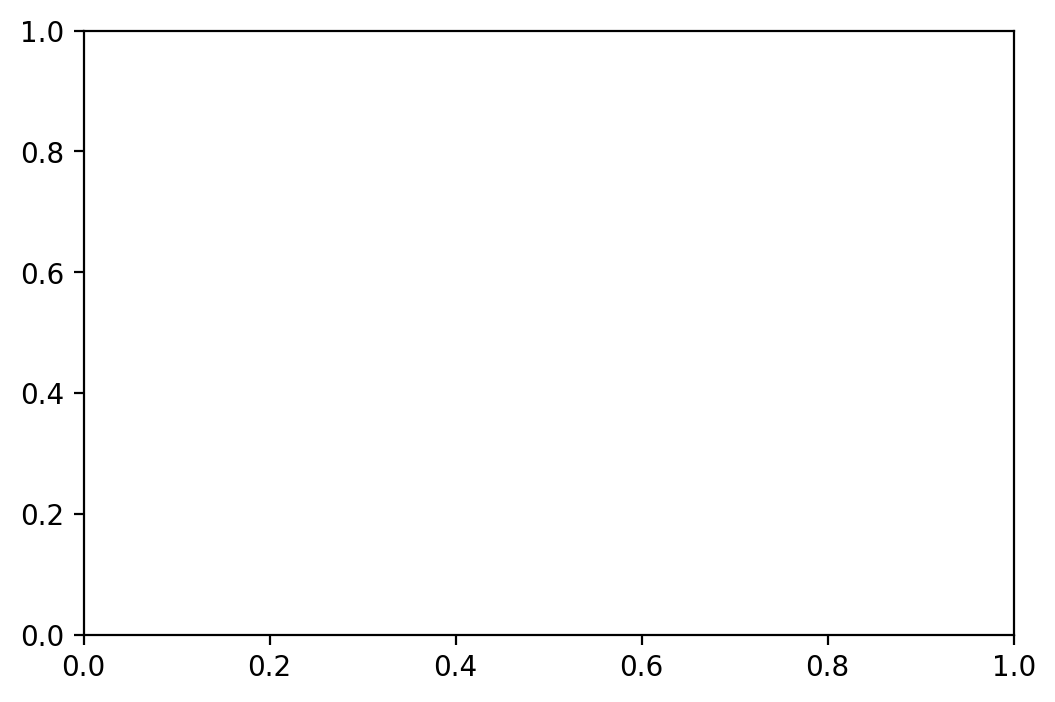

In [7]:
cam4metric.plot1D('CLMODIS');

____

In [8]:
cam4da = cam4metric.get_case('cam4_1deg_release_amip').case_da

In [9]:
cam4da['CLMODIS']

<xarray.DataArray 'CLMODIS' (time: 122, cosp_prs: 7, cosp_tau_modis: 6, lat: 192, lon: 288)>
[283336704 values with dtype=float32]
Coordinates:
  * cosp_prs        (cosp_prs) float64 900.0 740.0 620.0 500.0 375.0 245.0 90.0
  * cosp_tau_modis  (cosp_tau_modis) float64 0.8 2.45 6.5 16.2 41.5 5.003e+04
  * lat             (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon             (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time            (time) object 2000-12-01 00:00:00 ... 2011-01-01 00:00:00
Attributes:
    mdims:         [12  3]
    units:         %
    long_name:     MODIS Cloud Area Fraction
    cell_methods:  time: mean

## Interpolate to the CAM grid

In [29]:
modis_old_interpd,_ = interp_like2D(modis_old,cam4da['CLMODIS'])

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xesmf/smm.py:98: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


### Copy over dataset-wide attributes

In [30]:
attrs = modis_old.attrs
# print(attrs['Comments'])

datestamp = datetime.today().strftime("%Y/%m/%d")
attrs['Comments'] = 'Interpolated to 1.25x1 deg CESM grid by Jonah Shaw (CU) on %s.' % datestamp
# print(attrs['Comments'])
modis_old_interpd = modis_old_interpd.assign_attrs(attrs)

### Create fake time coordinate.

In [31]:
modis_old_interpd = modis_old_interpd.assign_coords({'time':1})

modis_old_interpd['time'].attrs['calendar'] = '360_day'
modis_old_interpd['time'].attrs['units'] = "months since 1999-12-01"

modis_old_interpd = xr.decode_cf(modis_old_interpd)

In [5]:
save_dir = '/glade/work/jonahshaw/obs/MODIS/'
filename = 'MCD03_M3_NC_200207to201007.V01.nc'

In [35]:
modis_old_interpd.to_netcdf("%s/%s" % (save_dir,filename))

In [6]:
modis_old_interpd = xr.open_dataset("%s/%s" % (save_dir,filename))

In [37]:
cam4da['CLMODIS']

<xarray.DataArray 'CLMODIS' (time: 122, cosp_prs: 7, cosp_tau_modis: 6, lat: 192, lon: 288)>
[283336704 values with dtype=float32]
Coordinates:
  * cosp_prs        (cosp_prs) float64 900.0 740.0 620.0 500.0 375.0 245.0 90.0
  * cosp_tau_modis  (cosp_tau_modis) float64 0.8 2.45 6.5 16.2 41.5 5.003e+04
  * lat             (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon             (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time            (time) object 2000-12-01 00:00:00 ... 2011-01-01 00:00:00
Attributes:
    mdims:         [12  3]
    units:         %
    long_name:     MODIS Cloud Area Fraction
    cell_methods:  time: mean

In [ ]:
{'Optical_Thickness_vs_Cloud_Top_Pressure':'CLMODIS',}

cam4_1deg_release_amip.cam.h0.CLHMODIS.200011-201012.nc         
cam4_1deg_release_amip.cam.h0.LWPMODIS.200011-201012.nc           
cam4_1deg_release_amip.cam.h0.TAUWMODIS.200011-201012.nc  

cam4_1deg_release_amip.cam.h0.CLIMODIS.200011-201012.nc   
cam4_1deg_release_amip.cam.h0.CLLMODIS.200011-201012.nc  

cam4_1deg_release_amip.cam.h0.CLMMODIS.200011-201012.nc  


cam4_1deg_release_amip.cam.h0.CLMODIS.200011-201012.nc 

cam4_1deg_release_amip.cam.h0.TAUILOGMODIS.200011-201012.nc  
cam4_1deg_release_amip.cam.h0.TAUIMODIS.200011-201012.nc  
cam4_1deg_release_amip.cam.h0.IWPMODIS.200011-201012.nc          
cam4_1deg_release_amip.cam.h0.TAUTLOGMODIS.200011-201012.nc  
cam4_1deg_release_amip.cam.h0.TAUTMODIS.200011-201012.nc  
cam4_1deg_release_amip.cam.h0.TAUWLOGMODIS.200011-201012.nc  

In [8]:
modis_vars_dict = {'Cloud_Fraction_Retrieval_Total_Mean':'CLTMODIS',
                   'Cloud_Fraction_Retrieval_Low_Mean':'CLLMODIS',
                   'Cloud_Fraction_Retrieval_Mid_Mean':'CLMMODIS',
                   'Cloud_Fraction_Retrieval_High_Mean':'CLHMODIS',
                   'Cloud_Fraction_Retrieval_Liquid_Mean':'CLWMODIS',
                   'Cloud_Fraction_Retrieval_Ice_Mean':'CLIMODIS',
                   'Optical_Thickness_vs_Cloud_Top_Pressure':'CLMODIS',
                   'Liquid_Path_Mean':'LWPMODIS',
                   'Ice_Path_Mean':'IWPMODIS',
                   'Cloud_Optical_Thickness_Liquid_Mean':'TAUWMODIS',
                   'Cloud_Optical_Thickness_Liquid_MeanLog10':'TAUWLOGMODIS',
                   'Cloud_Optical_Thickness_Ice_MeanLog10':'TAUILOGMODIS',
                   'Cloud_Optical_Thickness_Ice_Mean':'TAUIMODIS',
                   'Cloud_Optical_Thickness_Total_Mean':'TAUTMODIS',
                   'Cloud_Optical_Thickness_Total_MeanLog10':'TAUTLOGMODIS',
                   'Cloud_Top_Pressure_Total_Mean':'PCTMODIS',
                   'Cloud_Particle_Size_Liquid_Mean':'REFFCLWMODIS',
                   'Cloud_Particle_Size_Ice_Mean':'REFFCLIMODIS',}


In [11]:
modis_final = modis_old_interpd.rename(modis_vars_dict)

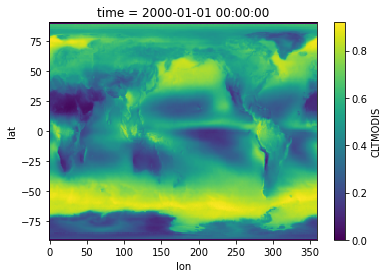

In [14]:
modis_final['CLTMODIS'].plot()